In [110]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering, ward_tree
from sklearn.metrics import plot_confusion_matrix, accuracy_score, mean_squared_error
from sklearn.naive_bayes import GaussianNB
import yfinance as yf
import pmdarima as pm
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

os.chdir('../')
from src.features.build_features import (
    daily_return, uniform_clustering, create_shifted_rt, downloading_stocks_data, return_in_period, binary_clustering)
from src.evaluation.dm_test import dm_test
os.chdir('./notebooks')



# Aquisição dos dados

|Country|Index|Ticker|
|---        |---        |---        |
|Brazil|iBovespa|^BVSP|
|USA|Nasdaq Composite|^IXIC|
|USA|NYSE Composite|^NYA|
|USA|Dow Jones|^DJI|
|Argentina|Merval|M.BA|
|Japan|Nikkei 225|^N225|
|China|Shangai Composite|000001.SS|
|China|Hang Seng|^HSI|
|India|BSE 30 Sensex|^BSESN|
|UK|FTSE 100|^FTSE|
|Sweden|Stockholm General|^OMX|
|Germany|Dax|^GDAXI|
|France|Cac 40|^FCHI|

In [133]:
# Input 
start_date = "2011-01-01"
end_date = "2021-07-20"
ntest = 20
# janela = 19
bolsa = '^BVSP'

# Indices de bolsas:
# ^BVSP
# ^IXIC
# ^NYA
# ^DJI
# M.BA
# ^N225
# 000001.SS
# ^HSI
# ^BSESN
# ^FTSE
# ^OMX
# ^GDAXI
# ^FCHI


In [134]:
df_ibovespa = yf.download(bolsa, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


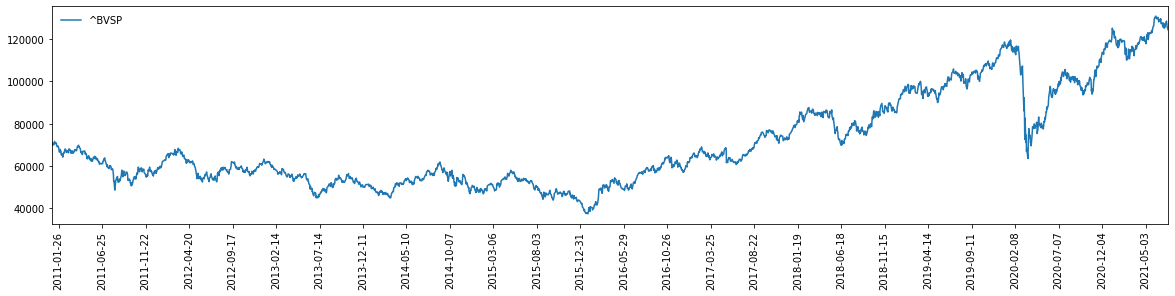

In [135]:
fig = plt.figure(figsize=(20, 4))
ax = fig.add_subplot(111)

ax.plot(df_ibovespa['Close'], label=bolsa)

date_min = df_ibovespa.index.min()
date_max = df_ibovespa.index.max()
ax.xaxis.set_major_locator(plt.MaxNLocator(30))
ax.set_xlim(left=date_min, right=date_max)

ax.legend(loc='upper left', frameon=False)
plt.xticks(rotation=90)
plt.show();

## Preparação dos dados

Nesta seção, tomaremos as seguintes ações:

1. Separação do conjunto de dados de treinamento (01/01/2011 até 30/04/2021) e de validação do modelo (01/05/2021 até 30/05/2021).
1. Criação do atributo **"p/e"**: $ p/e = 100*(ln({r_{t}}) - ln({r_{t-1}})) $.
1. Criação da resposta **cluster** usando apenas a simples separação. Lembrando que no artigo, os autores compararam duas abordagens diferentes para discretizar a resposta ((a) simples separação e (b) Ward).

In [136]:
# for cont in np.arange(ntest):
#     X_train = df_ibovespa[:-ntest+cont]
#     X_test = df_ibovespa[-ntest+cont:ntotal-ntest+1+cont]
    

#     print(f""" 
#     cont : {cont}
#     X_train: {X_train.shape} {X_train.index[-1]}
#     X_test: {X_test.shape} {X_test.index[-1]}\n""")

In [137]:
ntotal = df_ibovespa.shape[0]
resultado = {}

for cont in np.arange(ntest):
    X_train = df_ibovespa[:-ntest+cont]
    X_test = df_ibovespa[-ntest+cont:ntotal-ntest+1+cont]
    
    # X_test = df_ibovespa[-1:]

    # print(f""" 
    # cont : {cont}
    # X_train: {X_train.shape} {X_train.index[-1]}
    # X_test: {X_test.shape} {X_test.index[-1]}\n""")

    X_train["rt"] = (np.log(X_train["Close"]) - np.log(X_train["Close"].shift(periods=1)))*100
    X_test["rt"] = (np.log(X_test["Close"]) - np.log(X_test["Close"].shift(periods=1)))*100
    df_ibovespa["rt"] = (np.log(df_ibovespa["Close"]) - np.log(df_ibovespa["Close"].shift(periods=1)))*100
    X_train = X_train[["Close", "rt"]][1:]
    # X_train.head()


    model = pm.auto_arima(X_train['rt'], erro_action='ignore', trace=True, suppress_warnings=True, maxinter=10, stepwise=False, seasonal=False)

    # params = model.get_params()
    # d = params['order'][1]
    #train_pred = model.predict_in_sample(start=d, end=-1)
    test_pred, confint = model.predict(n_periods=1, return_conf_int=True)
    resultado[X_test.index[-1]] = test_pred[0]

    print(f"""test_pred, confint : {test_pred} {confint} """)


, Time=0.30 sec

Best model:  ARIMA(2,0,2)(0,0,0)[0]          
Total fit time: 7.849 seconds
test_pred, confint : [-0.07501982] [[-3.20127027  3.05123063]] 
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=9833.318, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=9813.702, Time=0.07 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=9809.680, Time=0.16 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=9811.364, Time=0.21 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=9813.294, Time=0.33 sec
 ARIMA(0,0,5)(0,0,0)[0]             : AIC=9810.998, Time=0.40 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=9811.794, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=9810.865, Time=0.10 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=9811.481, Time=0.29 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=9813.356, Time=0.50 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=9801.232, Time=0.82 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=9809.669, Time=0.10 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=9811.649,

In [120]:
X_real = df_ibovespa[-ntest:]
X_train_init = df_ibovespa[:-ntest]

In [121]:
resultado = pd.DataFrame.from_dict(resultado, orient='index', columns=['rt_predict'])

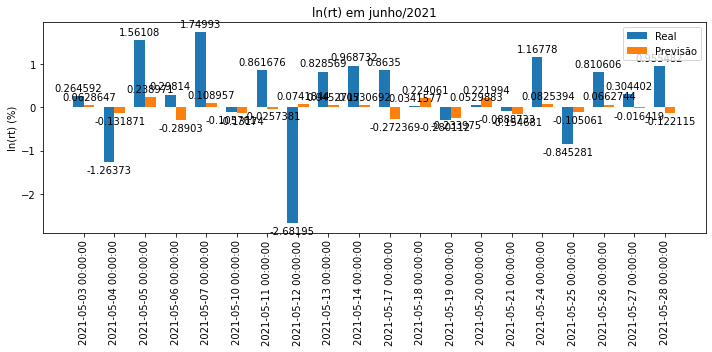

In [122]:
x = np.arange(len(X_real))
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10,5))
rects1 = ax.bar(x - width/2, X_real['rt'], width, label='Real')
rects2 = ax.bar(x + width/2, resultado['rt_predict'], width, label='Previsão')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('ln(rt) (%)')
ax.set_title('ln(rt) em junho/2021')
ax.set_xticks(x)
ax.set_xticklabels(X_real.index)
plt.xticks(rotation=90)

ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)


fig.tight_layout()

plt.show()

In [123]:
def rmse(y, t):
    return np.sqrt(np.mean((t - y)**2))

In [124]:
print(f"RSME ARIMA:", rmse(resultado['rt_predict'], X_real['rt']))

RSME ARIMA: 1.0210020361343808


In [125]:
rt = dm_test(X_real['rt'],resultado['rt_predict'],X_real['rt'],h = 1, crit="MAD")
print(rt)

dm_return(DM=5.3469580630365074, p_value=3.684586482091358e-05)


In [126]:
resultado.loc[resultado['rt_predict'] > 0, 'rt_predict'] = 1
resultado.loc[resultado['rt_predict'] < 0, 'rt_predict'] = 0

In [127]:
X_real.loc[X_real['rt'] > 0, 'rt'] = 1
X_real.loc[X_real['rt'] < 0, 'rt'] = 0

In [128]:
from sklearn.metrics import accuracy_score

In [129]:
accuracy_score(X_real['rt'], resultado['rt_predict'])

0.7

In [130]:
resultado['rt_predict']

2021-05-03    1.0
2021-05-04    0.0
2021-05-05    1.0
2021-05-06    0.0
2021-05-07    1.0
2021-05-10    0.0
2021-05-11    0.0
2021-05-12    1.0
2021-05-13    1.0
2021-05-14    1.0
2021-05-17    0.0
2021-05-18    1.0
2021-05-19    0.0
2021-05-20    1.0
2021-05-21    0.0
2021-05-24    1.0
2021-05-25    0.0
2021-05-26    1.0
2021-05-27    0.0
2021-05-28    0.0
Name: rt_predict, dtype: float64

In [131]:
X_real['rt']

Date
2021-05-03    1.0
2021-05-04    0.0
2021-05-05    1.0
2021-05-06    1.0
2021-05-07    1.0
2021-05-10    0.0
2021-05-11    1.0
2021-05-12    0.0
2021-05-13    1.0
2021-05-14    1.0
2021-05-17    1.0
2021-05-18    1.0
2021-05-19    0.0
2021-05-20    1.0
2021-05-21    0.0
2021-05-24    1.0
2021-05-25    0.0
2021-05-26    1.0
2021-05-27    1.0
2021-05-28    1.0
Name: rt, dtype: float64